In [3]:
from cProfile import label
from pickletools import optimize
from random import sample
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

1-1 AV : [-0.06942705  0.93964326  1.9680026   3.0066729   3.957079    4.859564  ]
1-1 SG : [0.2525493  0.5304543  0.85987383 1.1298923  1.2942165  1.327933  ]
1-2 AV : [0.07903071 1.0620263  2.0801063  3.135235   4.168872   5.122463  ]
1-2 SG : [0.2962563  0.40760738 0.42169642 0.38976172 0.3761021  0.33750662]


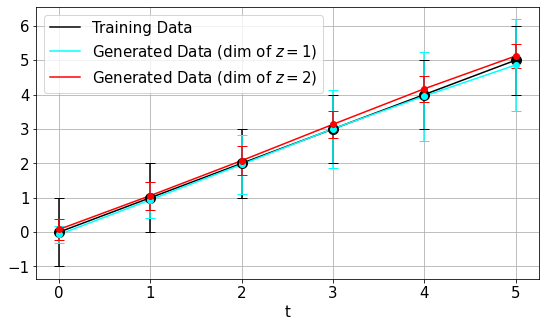

In [83]:
length = 6
place = "shuron/"
name = "1"

dim1_gene_av = np.load("Array/1_1_av.npy").reshape(-1)
dim1_gene_sg = np.load("Array/1_1_sg.npy").reshape(-1)
print("1-1 AV :", dim1_gene_av)
print("1-1 SG :",dim1_gene_sg)

dim2_gene_av = np.load("Array/1_2_av.npy").reshape(-1)
dim2_gene_sg = np.load("Array/1_2_sg.npy").reshape(-1)
print("1-2 AV :",dim2_gene_av)
print("1-2 SG :",dim2_gene_sg)

training_av = torch.tensor([i * 1.0 for i in range(length)])
training_sg = torch.tensor([1.0 for i in range(length)])

FS = 15
fig = plt.figure(figsize=(9, 5))
# plt.title("Sin Curves")
plt.xlabel("t", fontsize=15)
# plt.ylabel("y", fontsize=FS)
plt.rcParams["font.size"] = FS
training_color = "black"
plt.errorbar(np.arange(0,length), training_av.detach().numpy(), yerr = training_sg.detach().numpy(), capsize=5, fmt='o', markersize=10, ecolor='black', markeredgecolor = "black", color='black')
plt.plot(np.arange(0,length), training_av.detach().numpy(),color='black', label="Training Data")
gene_color = "cyan"
plt.errorbar(np.arange(0,length), dim1_gene_av, yerr = dim1_gene_sg, capsize=5, fmt='o', markersize=6, ecolor=gene_color, markeredgecolor = gene_color, color=gene_color)
plt.plot(np.arange(0,length), dim1_gene_av,color=gene_color, label="Generated Data " + "(dim of " + r"$z=1$)")
gene_color = "red"
plt.errorbar(np.arange(0,length), dim2_gene_av, yerr = dim2_gene_sg, capsize=5, fmt='o', markersize=6, ecolor=gene_color, markeredgecolor = gene_color, color=gene_color)
plt.plot(np.arange(0,length), dim2_gene_av,color=gene_color, label="Generated Data "+ "(dim of " + r"$z=2$)")
# plt.xticks([0,1,2,3], [0,1,2,3], size=15)
# plt.yticks([0, 3, 6, 9], [0, 3, 6, 9],size=15)
plt.grid()
plt.legend()
plt.savefig(place + name +  "_result.pdf")

# 実験1-1

In [57]:
name = "1_1"
place = "shuron/"

loss_hist = np.load("Array/" + name + "_loss.npy")
wloss_hist = np.load("Array/" + name + "_wloss.npy")
mmd_hist = np.load("Array/" + name + "_mmd.npy")
hyper = np.load("Array/" + name + "_hyper.npy")
test_data = np.load("Array/" + name + "_test.npy")
xreconstructed = np.load("Array/" + name + "_xreconstructed.npy")
zreconstructed = np.load("Array/" + name + "_zreconstructed.npy")
zreconstructed_q = np.load("Array/" + name + "_zreconstructed_q.npy")
zgenerated = np.load("Array/" + name + "_zgenerated.npy")
xgenerated = np.load("Array/" + name + "_xgenerated.npy")
print(hyper)

[2.e+03 1.e-03]


損失関数の描画

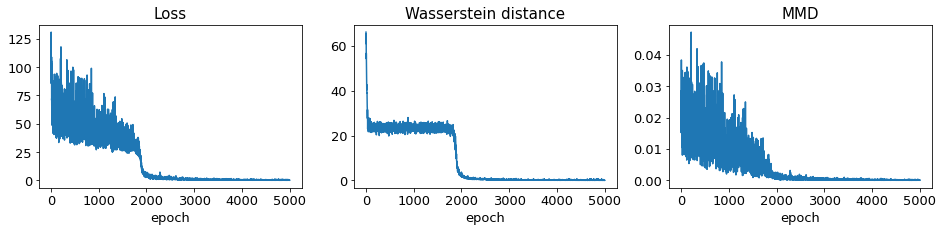

In [58]:
plt.figure(figsize=(16,3))
FontSize = 13
plt.rcParams["font.size"] = FontSize
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")
plt.savefig(place + name + "_loss.pdf")
plt.show()
plt.close()

空間$\mathcal{X}$上の描画

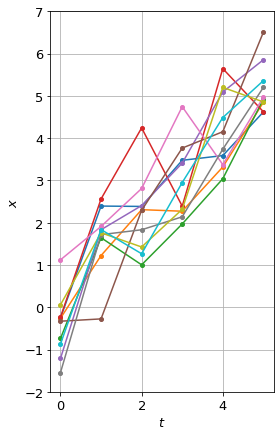

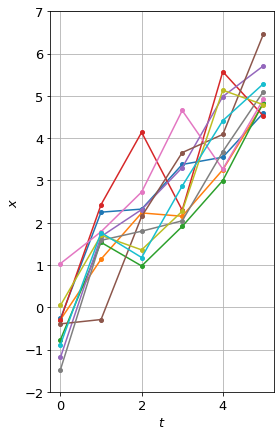

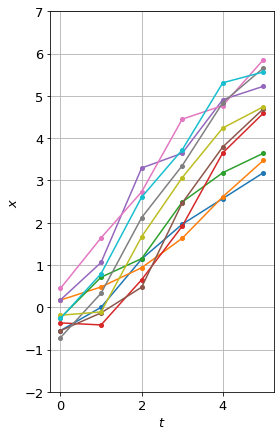

In [60]:
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place= "NO"):
    # xdata = xdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 1:
        # 時系列データの第一成分をプロット
        plt.figure(figsize=(4,7))
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$")
        plt.ylabel(r"$x$")
        y_lim = [-2.0, 7.0]
        plt.ylim(y_lim)
        # plt.title(r"$x(t)$ (" + type_of_data +", sample:" + str(xdata.shape[0]) + ")")
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_data(test_data, name, "xtrain", place)
plot_data(xreconstructed, name, "xrecon", place)
plot_data(xgenerated, name, "xgene",place)

空間$\mathcal{Z}$上での描画

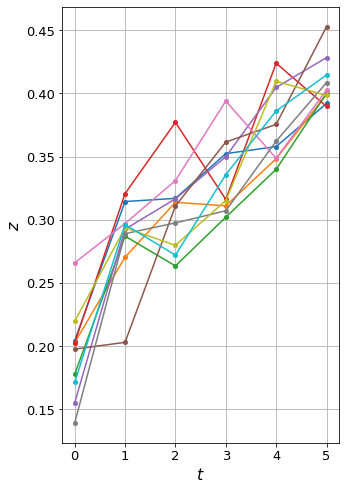

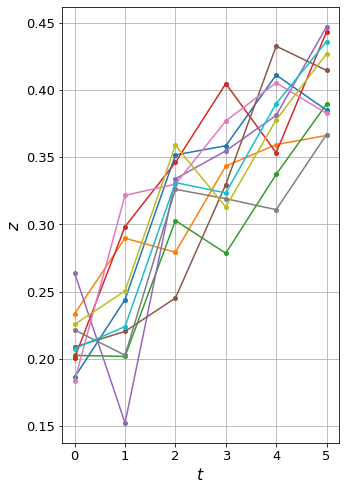

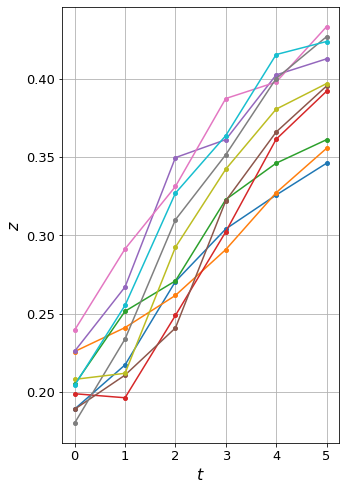

In [61]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place="NO"):
    # zdata = zdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if zdata.shape[-1] == 1:
        # 時系列データの第一成分をプロット
        plt.figure(figsize=(5,7))
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size= 16)
        plt.ylabel(r"$z$", size= 16)
        # y_lim = 3.0
        # plt.ylim(1.8, 3.2)
        # plt.title(r"$z(t)$ of" + type_of_data)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()


plot_zdata(zreconstructed_q, name, "zinference", place)
plot_zdata(zreconstructed, name, "zrecon", place)
plot_zdata(zgenerated, name, "zgene", place)

# 実験1-2

In [62]:
name = "1_2"
place = "shuron/"

loss_hist = np.load("Array/" + name + "_loss.npy")
wloss_hist = np.load("Array/" + name + "_wloss.npy")
mmd_hist = np.load("Array/" + name + "_mmd.npy")
hyper = np.load("Array/" + name + "_hyper.npy")
test_data = np.load("Array/" + name + "_test.npy")
xreconstructed = np.load("Array/" + name + "_xreconstructed.npy")
zreconstructed = np.load("Array/" + name + "_zreconstructed.npy")
zreconstructed_q = np.load("Array/" + name + "_zreconstructed_q.npy")
zgenerated = np.load("Array/" + name + "_zgenerated.npy")
xgenerated = np.load("Array/" + name + "_xgenerated.npy")
print(hyper)

[2.e+03 1.e-03]


損失関数の描画

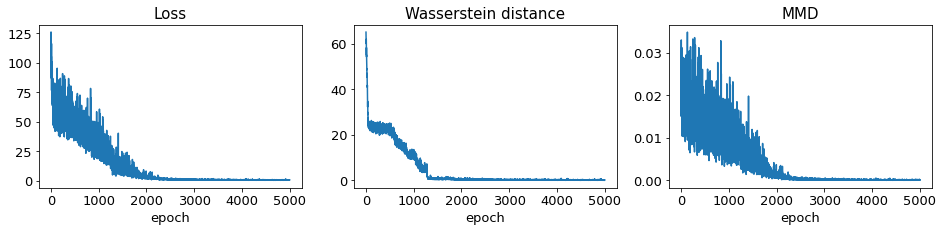

In [63]:
plt.figure(figsize=(16,3))
FontSize = 13
plt.rcParams["font.size"] = FontSize
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")
plt.savefig(place + name + "_loss.pdf")
plt.show()
plt.close()

空間$\mathcal{X}$上の描画

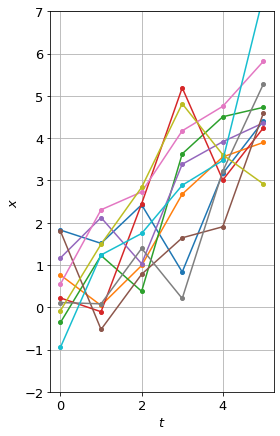

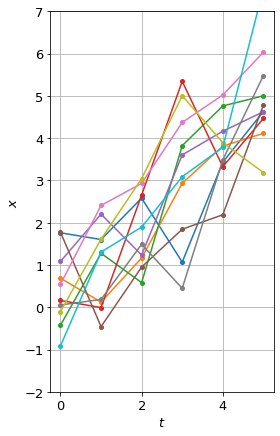

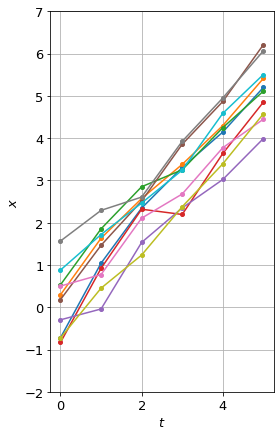

In [65]:
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place= "NO"):
    # xdata = xdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 1:
        # 時系列データの第一成分をプロット
        plt.figure(figsize=(4,7))
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$")
        plt.ylabel(r"$x$")
        y_lim = [-2.0, 7.0]
        plt.ylim(y_lim)
        # plt.title(r"$x(t)$ (" + type_of_data +", sample:" + str(xdata.shape[0]) + ")")
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_data(test_data, name, "xtrain", place)
plot_data(xreconstructed, name, "xrecon", place)
plot_data(xgenerated, name, "xgene",place)

空間$\mathcal{Z}$上での描画

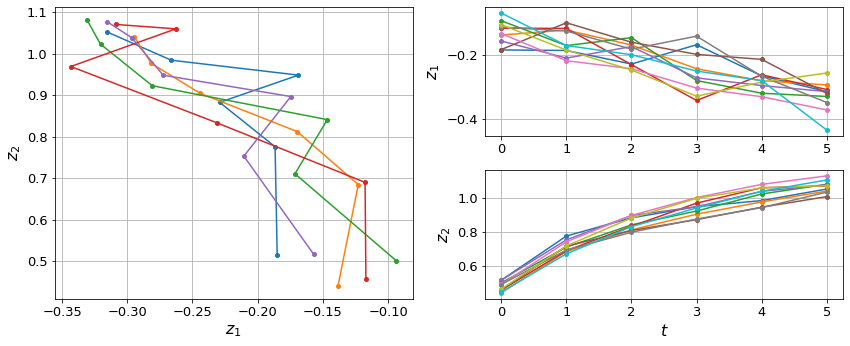

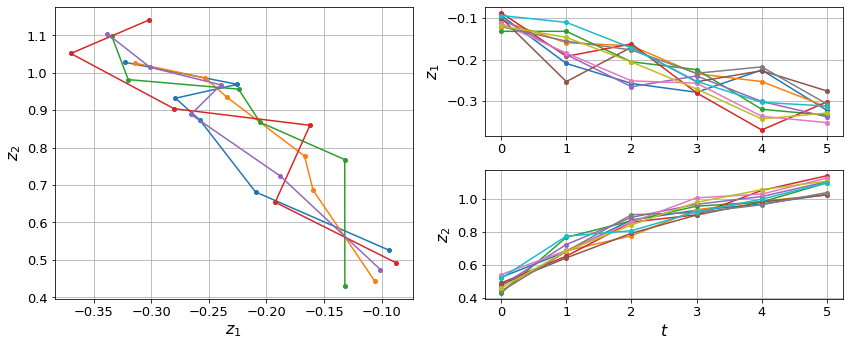

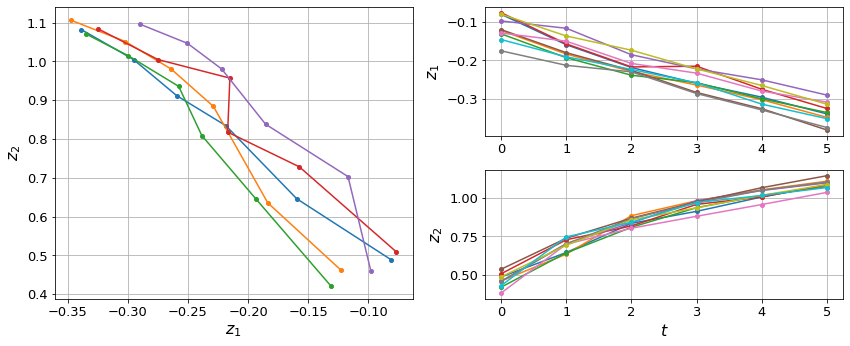

In [26]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place="NO"):
    # zdata = zdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if zdata.shape[-1] == 2:
        plt.figure(figsize=((12,5)))
        plt.subplot(121)
        # 時系列データを二次元平面上の軌道としてプロットする
        for i in range(5):
            plt.plot(zdata[i,:,0],zdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$z_1$", size= 16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$z_2$", size= 16)
        # x_lim = [-1.0, 1.0] 
        # y_lim = [-1.0, 1.0]
        # plt.xlim(x_lim)
        # plt.ylim(y_lim)
    
        # plt.title("Trajectories of " + type_of_data)

        # 時系列データの第一成分をプロット
        plt.subplot(222)
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        # plt.xlabel(r"$t$")
        plt.ylabel(r"$z_1$", size= 16)
        # plt.ylim(x_lim)
        # plt.title(r"$z_1(t)$ and $z_2(t)$ of " + type_of_data)
        
        # 時系列データの第二成分をプロット
        plt.subplot(224)
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size= 16)
        plt.ylabel(r"$z_2$", size= 16)
        # plt.ylim(y_lim)
        # plt.title(r"$z_2(t)$ (" + type_of_data +", sample:" + str(zdata.shape[0]) + ")")
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_zdata(zreconstructed_q, name, "zinference", place)
plot_zdata(zreconstructed, name, "zrecon", place)
plot_zdata(zgenerated, name, "zgene", place)

# 実験2-1

In [108]:
name = "2_1"
place = "shuron/"

loss_hist = np.load("Array/" + name + "_loss.npy")
wloss_hist = np.load("Array/" + name + "_wloss.npy")
mmd_hist = np.load("Array/" + name + "_mmd.npy")
hyper = np.load("Array/" + name + "_hyper.npy")
test_data = np.load("Array/" + name + "_test.npy")
xreconstructed = np.load("Array/" + name + "_xreconstructed.npy")
zreconstructed = np.load("Array/" + name + "_zreconstructed.npy")
zreconstructed_q = np.load("Array/" + name + "_zreconstructed_q.npy")
zgenerated = np.load("Array/" + name + "_zgenerated.npy")
xgenerated = np.load("Array/" + name + "_xgenerated.npy")
print(hyper)

[5.e+01 5.e-04]


損失関数の描画

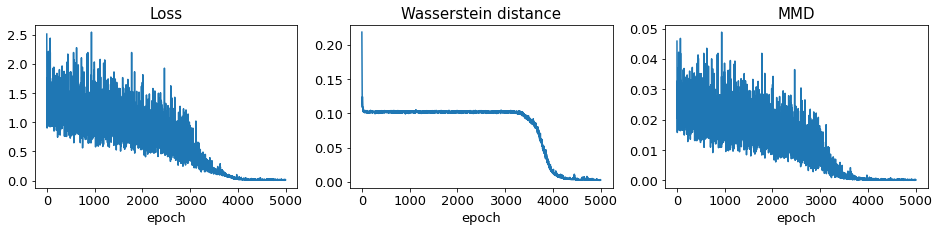

In [85]:
plt.figure(figsize=(16,3))
FontSize = 13
plt.rcParams["font.size"] = FontSize
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")
plt.savefig(place + name + "_loss.pdf")
plt.show()
plt.close()

空間$\mathcal{X}$上の描画

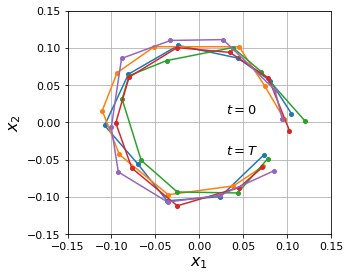

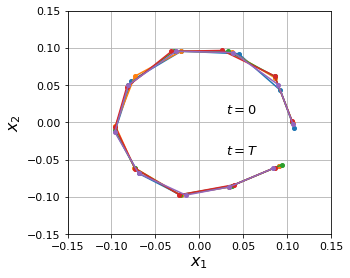

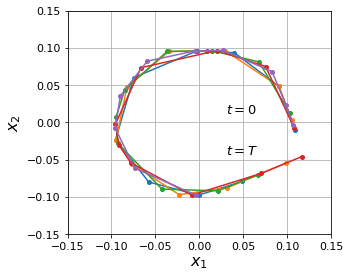

In [103]:
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place= "NO"):
    # xdata = xdata.data.cpu().numpy()
    FontSize = 11
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 2:
        # 時系列データを二次元平面上の軌道としてプロットする
        plt.figure(figsize=(5,4))
        # plt.subplot(121)
        for i in range(5):
            plt.plot(xdata[i,:,0],xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$x_1$", size=16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$x_2$", size=16)
        x_lim = [-0.15, 0.15] 
        y_lim = [-0.15, 0.15]
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        plt.text(0.03, 0.025, r"$t=0$", fontsize=13, verticalalignment='top')
        plt.text(0.03, -0.03, r"$t=T$", fontsize=13, verticalalignment='top')
    
        # # 時系列データの第一成分をプロット
        # plt.subplot(222)
        # for i in range(xdata.shape[0]):
        #     plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        # plt.grid()
        # # plt.xlabel(r"$t$")
        # plt.ylabel(r"$x_1$", size=16)
        # # plt.ylim(x_lim)
    
        # # 時系列データの第二成分をプロット
        # plt.subplot(224)
        # for i in range(xdata.shape[0]):
        #     plt.plot(xdata[i,:,1], marker='o', markersize = 4)
        # plt.grid()
        # plt.xlabel(r"$t$", size=16)
        # plt.ylabel(r"$x_2$", size=16)
        # # plt.ylim(y_lim)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig( place +type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_data(test_data, name, "xtrain", place)
plot_data(xreconstructed, name, "xrecon", place)
plot_data(xgenerated, name, "xgene",place)

空間$\mathcal{Z}$上での描画

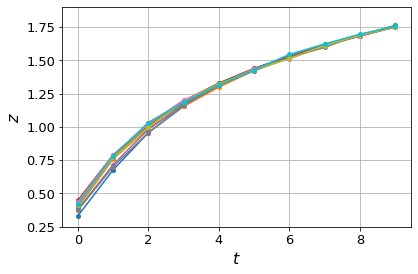

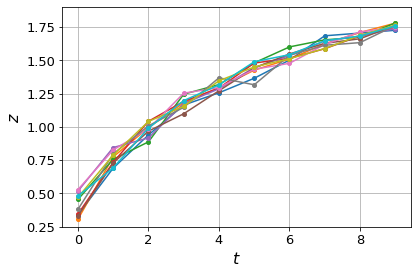

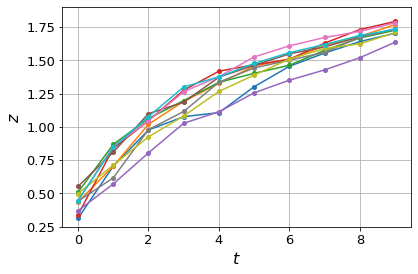

In [106]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place="NO"):
    # zdata = zdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if zdata.shape[-1] == 1:
        # 時系列データの第一成分をプロット
        plt.figure(figsize=(6,4))
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size= 16)
        plt.ylabel(r"$z$", size= 16)
        # y_lim = 3.0
        plt.ylim(0.25, 1.9)
        # plt.title(r"$z(t)$ of" + type_of_data)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

    

plot_zdata(zreconstructed_q, name, "zinference", place)
plot_zdata(zreconstructed, name, "zrecon", place)
plot_zdata(zgenerated, name, "zgene", place)

# 実験2-2

In [109]:
name = "2_2"
place = "shuron/"

loss_hist = np.load("Array/" + name + "_loss.npy")
wloss_hist = np.load("Array/" + name + "_wloss.npy")
mmd_hist = np.load("Array/" + name + "_mmd.npy")
hyper = np.load("Array/" + name + "_hyper.npy")
test_data = np.load("Array/" + name + "_test.npy")
xreconstructed = np.load("Array/" + name + "_xreconstructed.npy")
zreconstructed = np.load("Array/" + name + "_zreconstructed.npy")
zreconstructed_q = np.load("Array/" + name + "_zreconstructed_q.npy")
zgenerated = np.load("Array/" + name + "_zgenerated.npy")
xgenerated = np.load("Array/" + name + "_xgenerated.npy")
print(hyper)

[1.e+02 5.e-04]


損失関数の描画

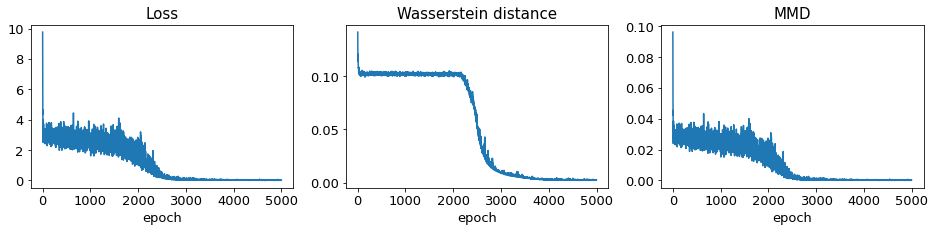

In [110]:
plt.figure(figsize=(16,3))
FontSize = 13
plt.rcParams["font.size"] = FontSize
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")
plt.savefig(place + name + "_loss.pdf")
plt.show()
plt.close()

空間$\mathcal{X}$上の描画

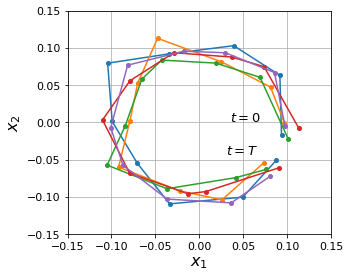

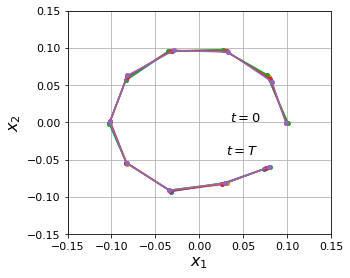

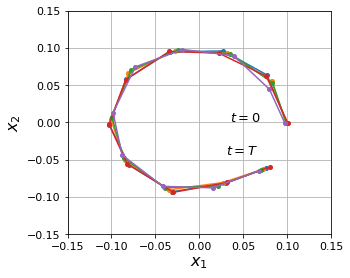

In [114]:
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place= "NO"):
    # xdata = xdata.data.cpu().numpy()
    FontSize = 11
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 2:
        # 時系列データを二次元平面上の軌道としてプロットする
        plt.figure(figsize=(5,4))
        # plt.subplot(121)
        for i in range(5):
            plt.plot(xdata[i,:,0],xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$x_1$", size=16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$x_2$", size=16)
        x_lim = [-0.15, 0.15] 
        y_lim = [-0.15, 0.15]
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        plt.text(0.035, 0.015, r"$t=0$", fontsize=13, verticalalignment='top')
        plt.text(0.03, -0.03, r"$t=T$", fontsize=13, verticalalignment='top')
    
        # # 時系列データの第一成分をプロット
        # plt.subplot(222)
        # for i in range(xdata.shape[0]):
        #     plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        # plt.grid()
        # # plt.xlabel(r"$t$")
        # plt.ylabel(r"$x_1$", size=16)
        # # plt.ylim(x_lim)
    
        # # 時系列データの第二成分をプロット
        # plt.subplot(224)
        # for i in range(xdata.shape[0]):
        #     plt.plot(xdata[i,:,1], marker='o', markersize = 4)
        # plt.grid()
        # plt.xlabel(r"$t$", size=16)
        # plt.ylabel(r"$x_2$", size=16)
        # # plt.ylim(y_lim)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig( place +type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_data(test_data, name, "xtrain", place)
plot_data(xreconstructed, name, "xrecon", place)
plot_data(xgenerated, name, "xgene",place)

空間$\mathcal{Z}$上での描画

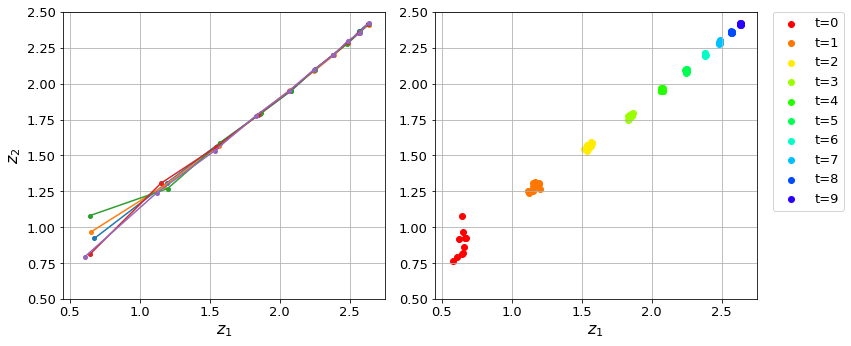

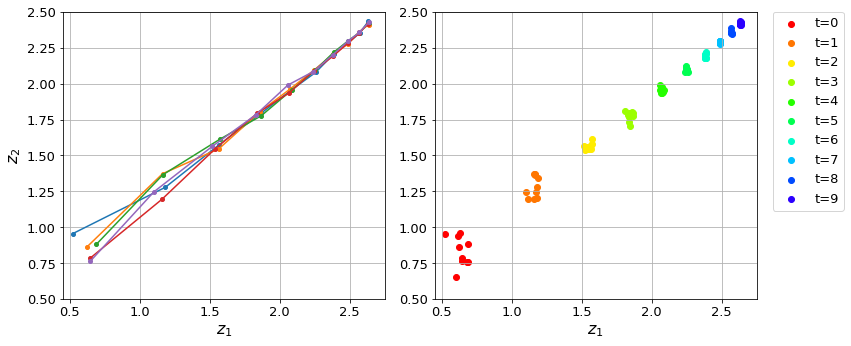

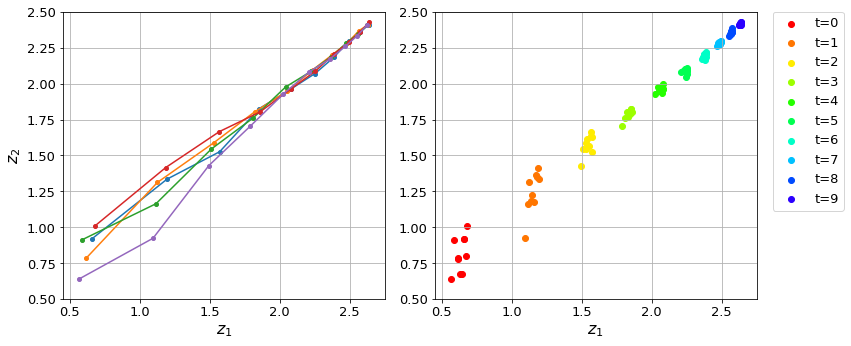

In [118]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place="NO"):
    # zdata = zdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if zdata.shape[-1] == 2:
        plt.figure(figsize=((12,5)))
        plt.subplot(121)
        # 時系列データを二次元平面上の軌道としてプロットする
        for i in range(5):
            plt.plot(zdata[i,:,0],zdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$z_1$", size= 16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$z_2$", size= 16)
        x_lim = [0.45, 2.75] 
        y_lim = [0.5, 2.5]
        plt.xlim(x_lim)
        plt.ylim(y_lim)

        # 時系列データを二次元平面上の軌道としてプロットする．ただし，時刻tごとにx(t)を色付けした散布図として表示する．
        plt.subplot(122)
        for i in range(zdata.shape[1]):
            plt.scatter(zdata[:,i,0], zdata[:,i,1], c=[cmap(i*20)], label="t="+str(i))
        plt.grid()
        plt.xlabel(r"$z_1$", size= 16) 
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        # plt.ylabel(r"$z_2(t)$", size= 16)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, ncol=1)
    
        # # plt.title("Trajectories of " + type_of_data)

        # # 時系列データの第一成分をプロット
        # plt.subplot(222)
        # for i in range(zdata.shape[0]):
        #     plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        # plt.grid()
        # # plt.xlabel(r"$t$")
        # plt.ylabel(r"$z_1$", size= 16)
        # # plt.ylim(x_lim)
        # # plt.title(r"$z_1(t)$ and $z_2(t)$ of " + type_of_data)
        
        # # 時系列データの第二成分をプロット
        # plt.subplot(224)
        # for i in range(zdata.shape[0]):
        #     plt.plot(zdata[i,:,1], marker='o', markersize = 4)
        # plt.grid()
        # plt.xlabel(r"$t$", size= 16)
        # plt.ylabel(r"$z_2$", size= 16)
        # # plt.ylim(y_lim)
        # # plt.title(r"$z_2(t)$ (" + type_of_data +", sample:" + str(zdata.shape[0]) + ")")
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_zdata(zreconstructed_q, name, "zinference", place)
plot_zdata(zreconstructed, name, "zrecon", place)
plot_zdata(zgenerated, name, "zgene", place)

# 実験2-3

In [119]:
name = "2_3"
place = "shuron/"

loss_hist = np.load("Array/" + name + "_loss.npy")
wloss_hist = np.load("Array/" + name + "_wloss.npy")
mmd_hist = np.load("Array/" + name + "_mmd.npy")
hyper = np.load("Array/" + name + "_hyper.npy")
test_data = np.load("Array/" + name + "_test.npy")
xreconstructed = np.load("Array/" + name + "_xreconstructed.npy")
zreconstructed = np.load("Array/" + name + "_zreconstructed.npy")
zreconstructed_q = np.load("Array/" + name + "_zreconstructed_q.npy")
zgenerated = np.load("Array/" + name + "_zgenerated.npy")
xgenerated = np.load("Array/" + name + "_xgenerated.npy")
print(hyper)

[5.e+01 5.e-04]


損失関数の描画

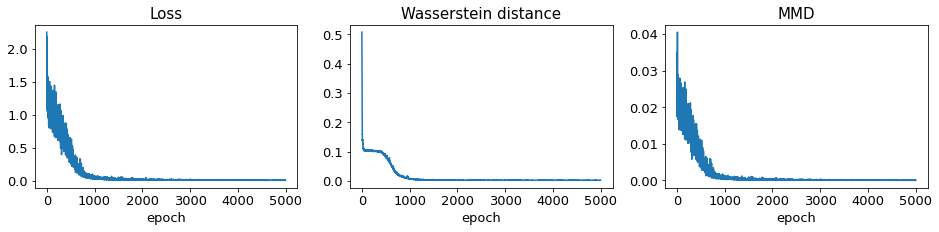

In [120]:
plt.figure(figsize=(16,3))
FontSize = 13
plt.rcParams["font.size"] = FontSize
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")
plt.savefig(place + name + "_loss.pdf")
plt.show()
plt.close()

空間$\mathcal{X}$上の描画

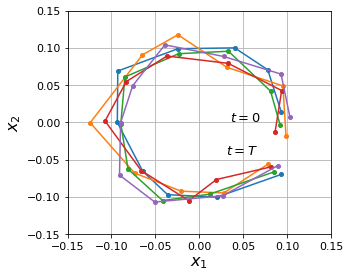

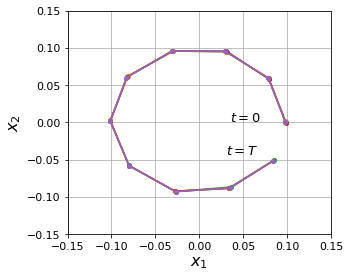

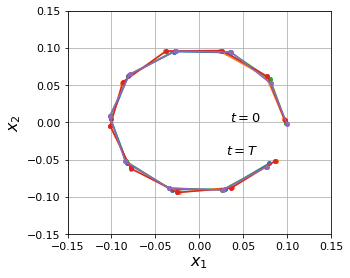

In [121]:
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place= "NO"):
    # xdata = xdata.data.cpu().numpy()
    FontSize = 11
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 2:
        # 時系列データを二次元平面上の軌道としてプロットする
        plt.figure(figsize=(5,4))
        # plt.subplot(121)
        for i in range(5):
            plt.plot(xdata[i,:,0],xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$x_1$", size=16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$x_2$", size=16)
        x_lim = [-0.15, 0.15] 
        y_lim = [-0.15, 0.15]
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        plt.text(0.035, 0.015, r"$t=0$", fontsize=13, verticalalignment='top')
        plt.text(0.03, -0.03, r"$t=T$", fontsize=13, verticalalignment='top')
    
        # # 時系列データの第一成分をプロット
        # plt.subplot(222)
        # for i in range(xdata.shape[0]):
        #     plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        # plt.grid()
        # # plt.xlabel(r"$t$")
        # plt.ylabel(r"$x_1$", size=16)
        # # plt.ylim(x_lim)
    
        # # 時系列データの第二成分をプロット
        # plt.subplot(224)
        # for i in range(xdata.shape[0]):
        #     plt.plot(xdata[i,:,1], marker='o', markersize = 4)
        # plt.grid()
        # plt.xlabel(r"$t$", size=16)
        # plt.ylabel(r"$x_2$", size=16)
        # # plt.ylim(y_lim)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig( place +type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()
        
plot_data(test_data, name, "xtrain", place)
plot_data(xreconstructed, name, "xrecon", place)
plot_data(xgenerated, name, "xgene",place)

空間$\mathcal{Z}$上での描画

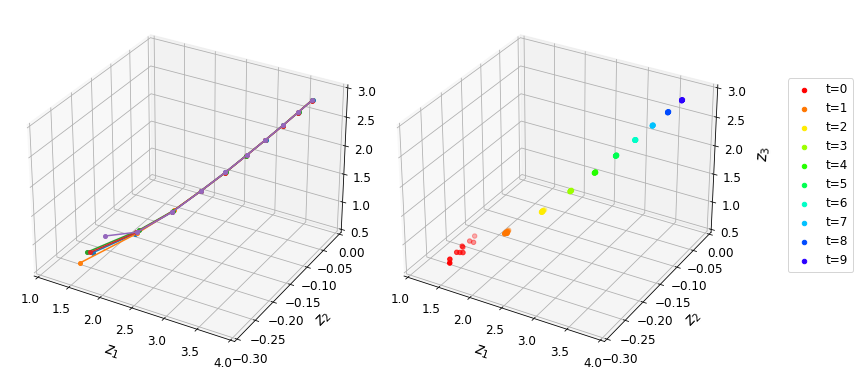

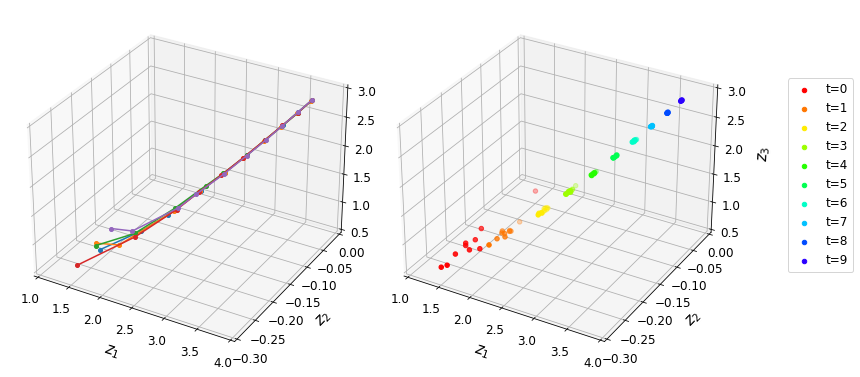

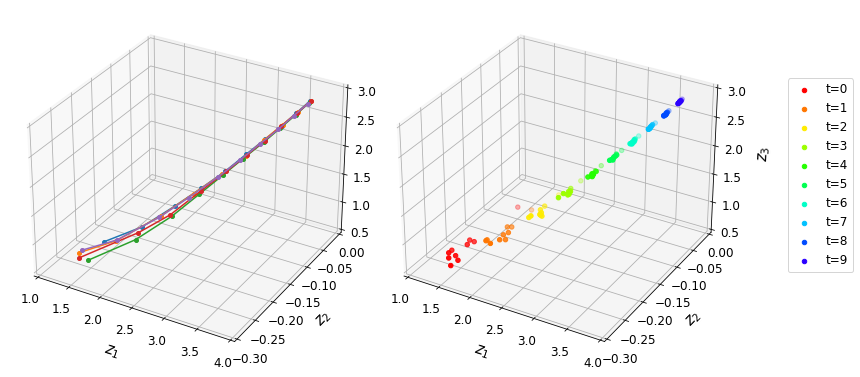

In [143]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place="NO"):
    # zdata = zdata.data.cpu().numpy()
    FontSize = 12
    plt.rcParams["font.size"] = FontSize
    if zdata.shape[-1] == 3:
        # 時系列データを三次元平面上の軌道としてプロットする
        fig = plt.figure(figsize=(12,7.5))
        ax = fig.add_subplot(121, projection='3d')
        ax.set_xlabel(r"$z_1$", labelpad=10, size= 15)
        ax.set_ylabel(r"$z_2$", labelpad=10, size= 15)
        ax.set_zlabel(r"$z_3$", labelpad=10, size= 15)
        for i in range(5):
            plt.plot(zdata[i,:,0],zdata[i,:,1], zdata[i,:,2], marker='o', markersize = 4)
        plt.grid()
        xlim = [1.0, 4.0]
        ylim = [-0.3, 0.0]
        zlim = [0.5, 3.0 ]
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)
        # plt.xlabel(r"$z_1$", size= 16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        # plt.ylabel(r"$z_2$", size= 16)
        # plt.zlabel(r"$z_3$")
        
        ax = fig.add_subplot(122, projection='3d')
        ax.set_xlabel(r"$z_1$", labelpad=10, size= 15)
        ax.set_ylabel(r"$z_2$", labelpad=10, size= 15)
        ax.set_zlabel(r"$z_3$", labelpad=10, size= 15)
        for i in range(zdata.shape[1]):
            ax.scatter(zdata[:,i,0],zdata[:,i,1], zdata[:,i,2], c=[cmap(i*20)], label="t="+str(i))
        plt.grid()
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)
        plt.legend(bbox_to_anchor=(1.15, 0.8), loc='upper left', borderaxespad=0, ncol=1)
        # # 時系列データの第一成分をプロット
        # plt.subplot(322)
        # for i in range(zdata.shape[0]):
        #     plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        # plt.grid()
        # # plt.xlabel(r"$t$")
        # plt.ylabel(r"$z_1$", size= 16)
        
        # # 時系列データの第二成分をプロット
        # plt.subplot(324)
        # for i in range(zdata.shape[0]):
        #     plt.plot(zdata[i,:,1], marker='o', markersize = 4)
        # plt.grid()
        # # plt.xlabel(r"$t$")
        # plt.ylabel(r"$z_2$", size= 16)
        # # plt.title(r"$z_2(t)$ (" + type_of_data +", sample:" + str(zdata.shape[0]) + ")")

        # # 時系列データの第三成分をプロット
        # plt.subplot(326)
        # for i in range(zdata.shape[0]):
        #     plt.plot(zdata[i,:,2], marker='o', markersize = 4)
        # plt.grid()
        # plt.xlabel(r"$t$", size= 16)
        # plt.ylabel(r"$z_3$", size= 16)
        # # plt.title(r"$z_3(t)$ (" + type_of_data +", sample:" + str(zdata.shape[0]) + ")")
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_zdata(zreconstructed_q, name, "zinference", place)
plot_zdata(zreconstructed, name, "zrecon", place)
plot_zdata(zgenerated, name, "zgene", place)

# 実験3-1

In [144]:
name = "3_1"
place = "shuron/"

loss_hist = np.load("Array/" + name + "_loss.npy")
wloss_hist = np.load("Array/" + name + "_wloss.npy")
mmd_hist = np.load("Array/" + name + "_mmd.npy")
hyper = np.load("Array/" + name + "_hyper.npy")
test_data = np.load("Array/" + name + "_test.npy")
xreconstructed = np.load("Array/" + name + "_xreconstructed.npy")
zreconstructed = np.load("Array/" + name + "_zreconstructed.npy")
zreconstructed_q = np.load("Array/" + name + "_zreconstructed_q.npy")
zgenerated = np.load("Array/" + name + "_zgenerated.npy")
xgenerated = np.load("Array/" + name + "_xgenerated.npy")
print(hyper)

[8.e+02 2.e-03]


損失関数の描画

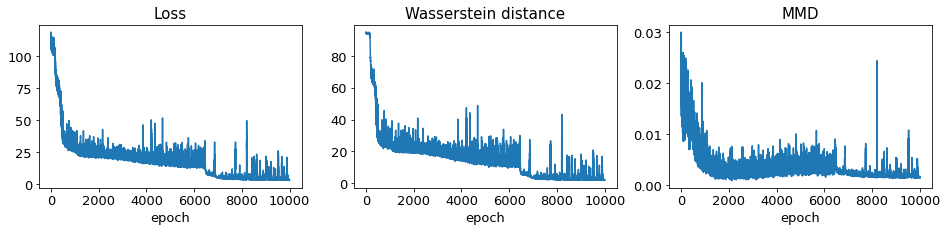

In [145]:
plt.figure(figsize=(16,3))
FontSize = 13
plt.rcParams["font.size"] = FontSize
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")
plt.savefig(place + name + "_loss.pdf")
plt.show()
plt.close()

空間$\mathcal{X}$上の描画

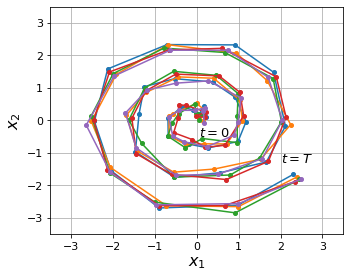

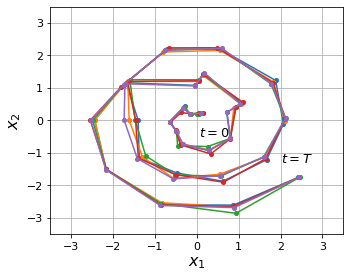

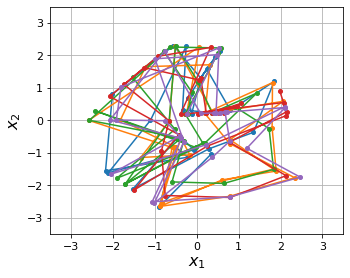

In [155]:
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place= "NO"):
    # xdata = xdata.data.cpu().numpy()
    FontSize = 11
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 2:
        # 時系列データを二次元平面上の軌道としてプロットする
        plt.figure(figsize=(5,4))
        # plt.subplot(121)
        for i in range(5):
            plt.plot(xdata[i,:,0],xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$x_1$", size=16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$x_2$", size=16)
        x_lim = [-3.5, 3.5] 
        y_lim = [-3.5, 3.5]
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        if saveName != "xgene":
            plt.text(0.05, -0.2, r"$t=0$", fontsize=13, verticalalignment='top')
            plt.text(2.0, -1.0, r"$t=T$", fontsize=13, verticalalignment='top')
        
        # # 時系列データの第一成分をプロット
        # plt.subplot(222)
        # for i in range(xdata.shape[0]):
        #     plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        # plt.grid()
        # # plt.xlabel(r"$t$")
        # plt.ylabel(r"$x_1$", size=16)
        # # plt.ylim(x_lim)
    
        # # 時系列データの第二成分をプロット
        # plt.subplot(224)
        # for i in range(xdata.shape[0]):
        #     plt.plot(xdata[i,:,1], marker='o', markersize = 4)
        # plt.grid()
        # plt.xlabel(r"$t$", size=16)
        # plt.ylabel(r"$x_2$", size=16)
        # # plt.ylim(y_lim)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig( place +type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_data(test_data, name, "xtrain", place)
plot_data(xreconstructed, name, "xrecon", place)
plot_data(xgenerated, name, "xgene",place)

空間$\mathcal{Z}$上での描画

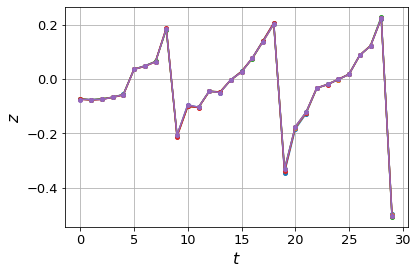

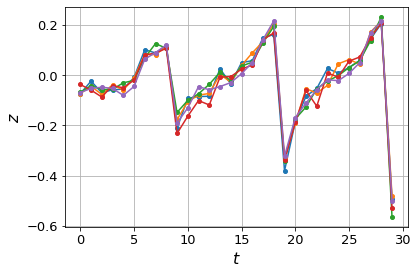

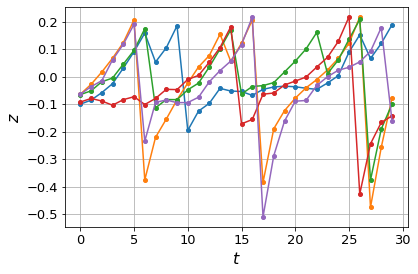

In [158]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place="NO"):
    # zdata = zdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if zdata.shape[-1] == 1:
        # 時系列データの第一成分をプロット
        plt.figure(figsize=(6,4))
        for i in range(5):
            plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size= 16)
        plt.ylabel(r"$z$", size= 16)
        # y_lim = 3.0
        # plt.ylim(1.8, 3.2)
        # plt.title(r"$z(t)$ of" + type_of_data)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_zdata(zreconstructed_q, name, "zinference", place)
plot_zdata(zreconstructed, name, "zrecon", place)
plot_zdata(zgenerated, name, "zgene", place)

# 実験3-2

In [179]:
name = "3_2"
place = "shuron/"

loss_hist = np.load("Array/" + name + "_loss.npy")
wloss_hist = np.load("Array/" + name + "_wloss.npy")
mmd_hist = np.load("Array/" + name + "_mmd.npy")
hyper = np.load("Array/" + name + "_hyper.npy")
test_data = np.load("Array/" + name + "_test.npy")
xreconstructed = np.load("Array/" + name + "_xreconstructed.npy")
zreconstructed = np.load("Array/" + name + "_zreconstructed.npy")
zreconstructed_q = np.load("Array/" + name + "_zreconstructed_q.npy")
zgenerated = np.load("Array/" + name + "_zgenerated.npy")
xgenerated = np.load("Array/" + name + "_xgenerated.npy")
print(hyper)

[8.e+02 3.e-03]


損失関数の描画

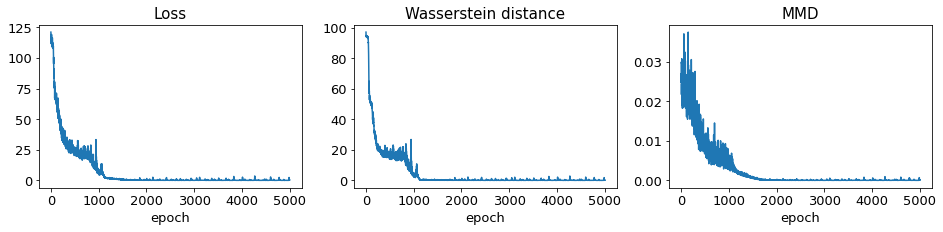

In [160]:
plt.figure(figsize=(16,3))
FontSize = 13
plt.rcParams["font.size"] = FontSize
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")
plt.savefig(place + name + "_loss.pdf")
plt.show()
plt.close()

空間$\mathcal{X}$上の描画

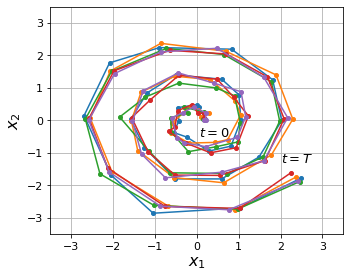

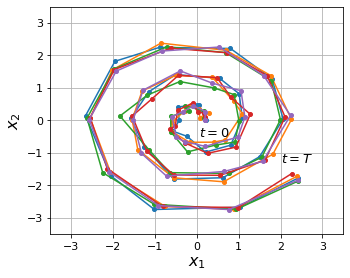

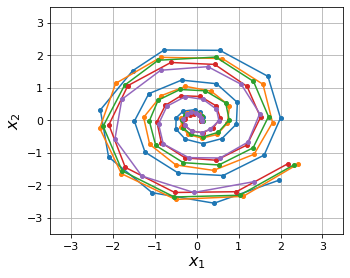

In [161]:
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place= "NO"):
    # xdata = xdata.data.cpu().numpy()
    FontSize = 11
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 2:
        # 時系列データを二次元平面上の軌道としてプロットする
        plt.figure(figsize=(5,4))
        # plt.subplot(121)
        for i in range(5):
            plt.plot(xdata[i,:,0],xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$x_1$", size=16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$x_2$", size=16)
        x_lim = [-3.5, 3.5] 
        y_lim = [-3.5, 3.5]
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        if saveName != "xgene":
            plt.text(0.05, -0.2, r"$t=0$", fontsize=13, verticalalignment='top')
            plt.text(2.0, -1.0, r"$t=T$", fontsize=13, verticalalignment='top')
        
        # # 時系列データの第一成分をプロット
        # plt.subplot(222)
        # for i in range(xdata.shape[0]):
        #     plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        # plt.grid()
        # # plt.xlabel(r"$t$")
        # plt.ylabel(r"$x_1$", size=16)
        # # plt.ylim(x_lim)
    
        # # 時系列データの第二成分をプロット
        # plt.subplot(224)
        # for i in range(xdata.shape[0]):
        #     plt.plot(xdata[i,:,1], marker='o', markersize = 4)
        # plt.grid()
        # plt.xlabel(r"$t$", size=16)
        # plt.ylabel(r"$x_2$", size=16)
        # # plt.ylim(y_lim)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig( place +type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_data(test_data, name, "xtrain", place)
plot_data(xreconstructed, name, "xrecon", place)
plot_data(xgenerated, name, "xgene",place)

空間$\mathcal{Z}$上での描画

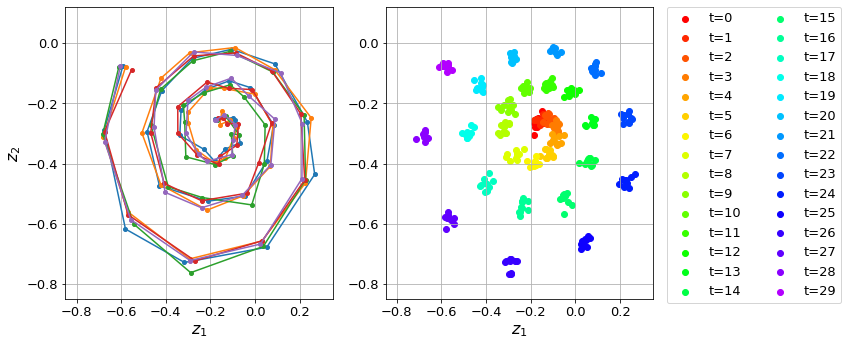

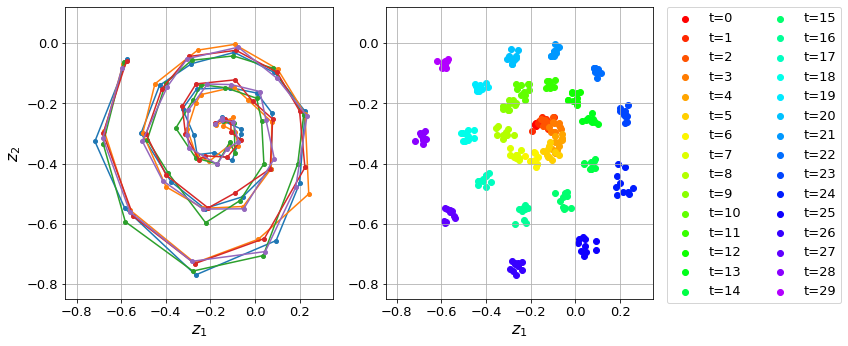

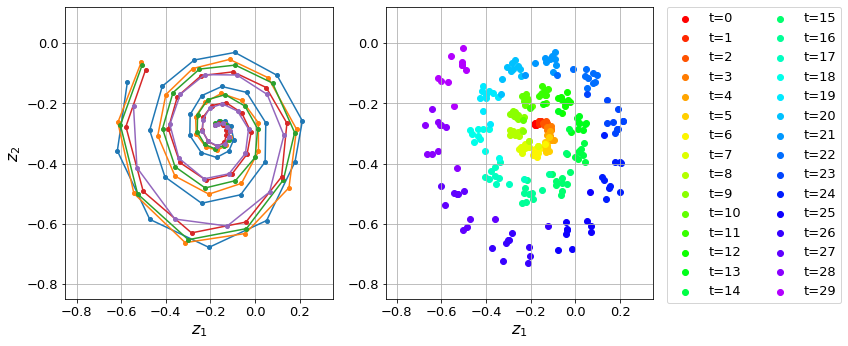

In [180]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place="NO"):
    # zdata = zdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if zdata.shape[-1] == 2:
        plt.figure(figsize=((12,5)))
        plt.subplot(121)
        # 時系列データを二次元平面上の軌道としてプロットする
        for i in range(5):
            plt.plot(zdata[i,:,0],zdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$z_1$", size= 16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$z_2$", size= 16)
        x_lim = [-0.85, 0.35] 
        y_lim = [-0.85, 0.12]
        plt.xlim(x_lim)
        plt.ylim(y_lim)

        # 時系列データを二次元平面上の軌道としてプロットする．ただし，時刻tごとにx(t)を色付けした散布図として表示する．
        plt.subplot(122)
        for i in range(zdata.shape[1]):
            plt.scatter(zdata[:,i,0], zdata[:,i,1], c=[cmap(i*7)], label="t="+str(i))
        plt.grid()
        plt.xlabel(r"$z_1$", size= 16) 
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        # plt.ylabel(r"$z_2(t)$", size= 16)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, ncol=2)
    
        # # plt.title("Trajectories of " + type_of_data)

        # # 時系列データの第一成分をプロット
        # plt.subplot(222)
        # for i in range(zdata.shape[0]):
        #     plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        # plt.grid()
        # # plt.xlabel(r"$t$")
        # plt.ylabel(r"$z_1$", size= 16)
        # # plt.ylim(x_lim)
        # # plt.title(r"$z_1(t)$ and $z_2(t)$ of " + type_of_data)
        
        # # 時系列データの第二成分をプロッ
        # plt.subplot(224)
        # for i in range(zdata.shape[0]):
        #     plt.plot(zdata[i,:,1], marker='o', markersize = 4)
        # plt.grid()
        # plt.xlabel(r"$t$", size= 16)
        # plt.ylabel(r"$z_2$", size= 16)
        # # plt.ylim(y_lim)
        # # plt.title(r"$z_2(t)$ (" + type_of_data +", sample:" + str(zdata.shape[0]) + ")")
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_zdata(zreconstructed_q, name, "zinference", place)
plot_zdata(zreconstructed, name, "zrecon", place)
plot_zdata(zgenerated, name, "zgene", place)

# 実験3-3

In [181]:
name = "3_3"
place = "shuron/"

loss_hist = np.load("Array/" + name + "_loss.npy")
wloss_hist = np.load("Array/" + name + "_wloss.npy")
mmd_hist = np.load("Array/" + name + "_mmd.npy")
hyper = np.load("Array/" + name + "_hyper.npy")
test_data = np.load("Array/" + name + "_test.npy")
xreconstructed = np.load("Array/" + name + "_xreconstructed.npy")
zreconstructed = np.load("Array/" + name + "_zreconstructed.npy")
zreconstructed_q = np.load("Array/" + name + "_zreconstructed_q.npy")
zgenerated = np.load("Array/" + name + "_zgenerated.npy")
xgenerated = np.load("Array/" + name + "_xgenerated.npy")
print(hyper)

[4.e+02 1.e-03]


損失関数の描画

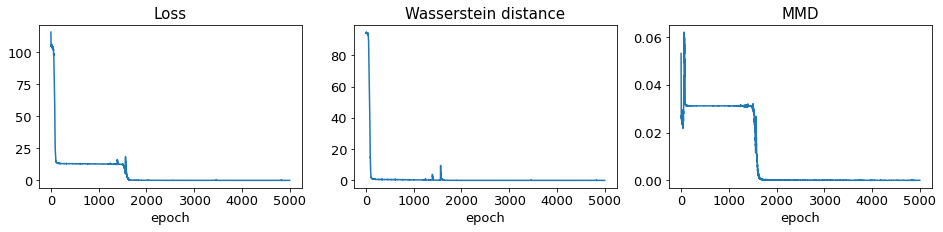

In [171]:
plt.figure(figsize=(16,3))
FontSize = 13
plt.rcParams["font.size"] = FontSize
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")
plt.savefig(place + name + "_loss.pdf")
plt.show()
plt.close()

空間$\mathcal{X}$上の描画

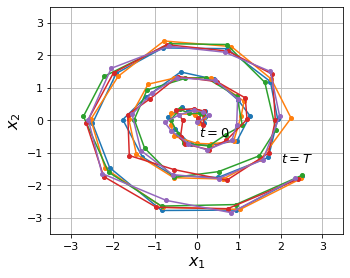

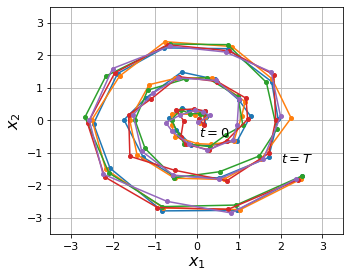

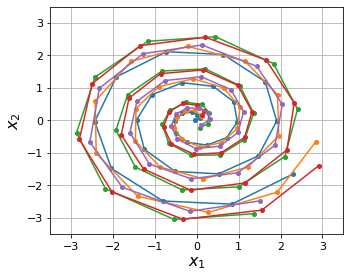

In [172]:
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place= "NO"):
    # xdata = xdata.data.cpu().numpy()
    FontSize = 11
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 2:
        # 時系列データを二次元平面上の軌道としてプロットする
        plt.figure(figsize=(5,4))
        # plt.subplot(121)
        for i in range(5):
            plt.plot(xdata[i,:,0],xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$x_1$", size=16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$x_2$", size=16)
        x_lim = [-3.5, 3.5] 
        y_lim = [-3.5, 3.5]
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        if saveName != "xgene":
            plt.text(0.05, -0.2, r"$t=0$", fontsize=13, verticalalignment='top')
            plt.text(2.0, -1.0, r"$t=T$", fontsize=13, verticalalignment='top')
        
        # # 時系列データの第一成分をプロット
        # plt.subplot(222)
        # for i in range(xdata.shape[0]):
        #     plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        # plt.grid()
        # # plt.xlabel(r"$t$")
        # plt.ylabel(r"$x_1$", size=16)
        # # plt.ylim(x_lim)
    
        # # 時系列データの第二成分をプロット
        # plt.subplot(224)
        # for i in range(xdata.shape[0]):
        #     plt.plot(xdata[i,:,1], marker='o', markersize = 4)
        # plt.grid()
        # plt.xlabel(r"$t$", size=16)
        # plt.ylabel(r"$x_2$", size=16)
        # # plt.ylim(y_lim)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig( place +type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_data(test_data, name, "xtrain", place)
plot_data(xreconstructed, name, "xrecon", place)
plot_data(xgenerated, name, "xgene",place)

空間$\mathcal{Z}$上での描画

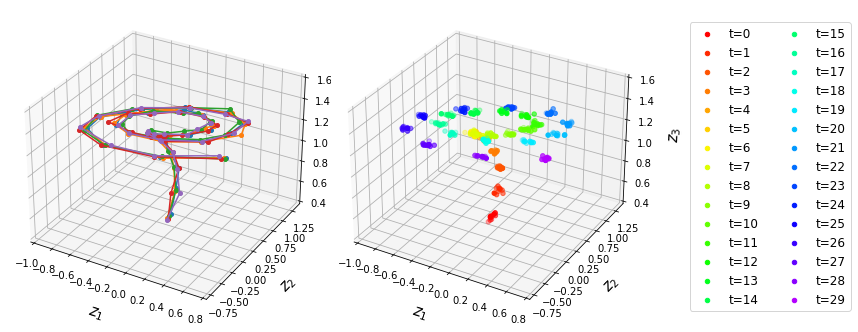

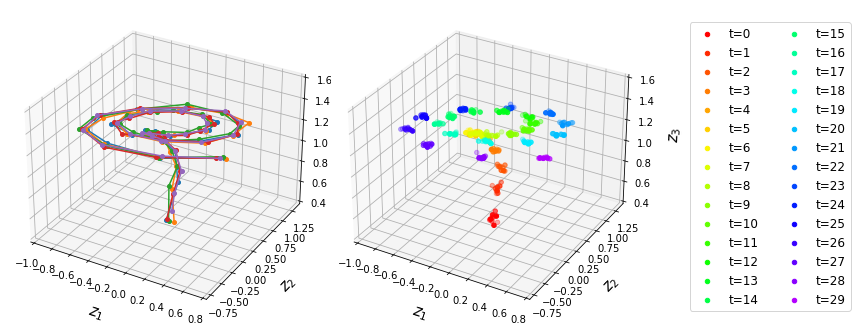

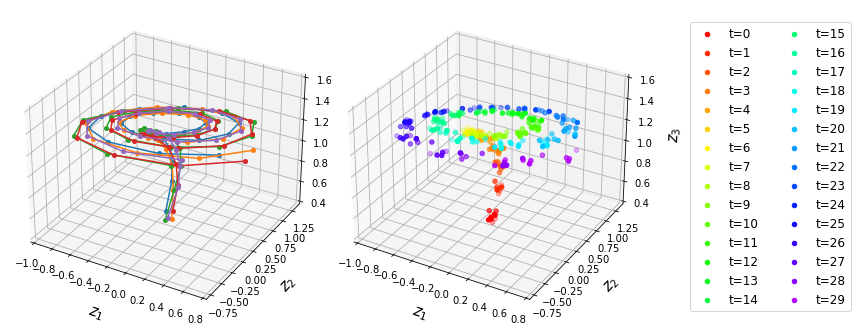

In [192]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place="NO"):
    # zdata = zdata.data.cpu().numpy()
    FontSize = 10
    plt.rcParams["font.size"] = FontSize
    if zdata.shape[-1] == 3:
        # 時系列データを三次元平面上の軌道としてプロットする
        fig = plt.figure(figsize=(12,7.5))
        ax = fig.add_subplot(121, projection='3d')
        ax.set_xlabel(r"$z_1$", labelpad=10, size= 15)
        ax.set_ylabel(r"$z_2$", labelpad=10, size= 15)
        ax.set_zlabel(r"$z_3$", labelpad=10, size= 15)
        for i in range(5):
            plt.plot(zdata[i,:,0],zdata[i,:,1], zdata[i,:,2], marker='o', markersize = 4)
        plt.grid()
        xlim = [-1.0, 0.8]
        ylim = [-0.8, 1.4]
        zlim = [0.4, 1.6 ]
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)
        # plt.xlabel(r"$z_1$", size= 16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        # plt.ylabel(r"$z_2$", size= 16)
        # plt.zlabel(r"$z_3$")
        
        ax = fig.add_subplot(122, projection='3d')
        ax.set_xlabel(r"$z_1$", labelpad=10, size= 15)
        ax.set_ylabel(r"$z_2$", labelpad=10, size= 15)
        ax.set_zlabel(r"$z_3$", labelpad=10, size= 15)
        for i in range(zdata.shape[1]):
            ax.scatter(zdata[:,i,0],zdata[:,i,1], zdata[:,i,2], c=[cmap(i*7)], label="t="+str(i))
        plt.grid()
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)
        plt.legend(bbox_to_anchor=(1.15, 0.95), loc='upper left', borderaxespad=0, ncol=2, fontsize = 12)
        # # 時系列データの第一成分をプロット
        # plt.subplot(322)
        # for i in range(zdata.shape[0]):
        #     plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        # plt.grid()
        # # plt.xlabel(r"$t$")
        # plt.ylabel(r"$z_1$", size= 16)
        
        # # 時系列データの第二成分をプロット
        # plt.subplot(324)
        # for i in range(zdata.shape[0]):
        #     plt.plot(zdata[i,:,1], marker='o', markersize = 4)
        # plt.grid()
        # # plt.xlabel(r"$t$")
        # plt.ylabel(r"$z_2$", size= 16)
        # # plt.title(r"$z_2(t)$ (" + type_of_data +", sample:" + str(zdata.shape[0]) + ")")

        # # 時系列データの第三成分をプロット
        # plt.subplot(326)
        # for i in range(zdata.shape[0]):
        #     plt.plot(zdata[i,:,2], marker='o', markersize = 4)
        # plt.grid()
        # plt.xlabel(r"$t$", size= 16)
        # plt.ylabel(r"$z_3$", size= 16)
        # # plt.title(r"$z_3(t)$ (" + type_of_data +", sample:" + str(zdata.shape[0]) + ")")
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_zdata(zreconstructed_q, name, "zinference", place)
plot_zdata(zreconstructed, name, "zrecon", place)
plot_zdata(zgenerated, name, "zgene", place)